# LSML2 Final Project

---
---

## 1. Dependencies and prerequisites

In [1]:
from google.colab import drive
drive.mount('/content/drive')
GDRIVE_WORKDIR = '/content/drive/MyDrive/_model'

Mounted at /content/drive


In [2]:
!pip install -q neptune

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.5/495.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import requests
import json
import random
import time
import os

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup

import neptune
from neptune.utils import stringify_unsupported
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## 2. Data loading

In [4]:
!wget https://dl.fbaipublicfiles.com/glue/superglue/data/v2/BoolQ.zip
!unzip BoolQ.zip

--2024-03-10 22:04:03--  https://dl.fbaipublicfiles.com/glue/superglue/data/v2/BoolQ.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.59, 13.227.219.33, 13.227.219.10, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4118001 (3.9M) [application/zip]
Saving to: ‘BoolQ.zip’

BoolQ.zip           100%[===================>]   3.93M  --.-KB/s    in 0.05s   

2024-03-10 22:04:04 (81.3 MB/s) - ‘BoolQ.zip’ saved [4118001/4118001]

Archive:  BoolQ.zip
   creating: BoolQ/
  inflating: BoolQ/train.jsonl       
  inflating: BoolQ/test.jsonl        
  inflating: BoolQ/val.jsonl         


In [5]:
raw_df = pd.read_json('BoolQ/train.jsonl', lines=True)
val_df = pd.read_json('BoolQ/val.jsonl', lines=True)
test_df = pd.read_json('BoolQ/test.jsonl', lines=True)

raw_df.shape, val_df.shape, test_df.shape

((9427, 4), (3270, 4), (3245, 3))

In [6]:
display(raw_df.head())
print()
display(val_df.head())
print()
display(test_df.head())

,question,passage,idx,label
0,do iran and afghanistan speak the same language,"Persian language -- Persian (/ˈpɜːrʒən, -ʃən/)...",0,True
1,do good samaritan laws protect those who help ...,Good Samaritan law -- Good Samaritan laws offe...,1,True
2,is windows movie maker part of windows essentials,Windows Movie Maker -- Windows Movie Maker (fo...,2,True
3,is confectionary sugar the same as powdered sugar,"Powdered sugar -- Powdered sugar, also called ...",3,True
4,is elder scrolls online the same as skyrim,The Elder Scrolls Online -- As with other game...,4,False


,question,passage,idx,label
0,does ethanol take more energy make that produces,Ethanol fuel -- All biomass goes through at le...,0,False
1,is house tax and property tax are same,Property tax -- Property tax or 'house tax' is...,1,True
2,is pain experienced in a missing body part or ...,Phantom pain -- Phantom pain sensations are de...,2,True
3,is harry potter and the escape from gringotts ...,Harry Potter and the Escape from Gringotts -- ...,3,True
4,is there a difference between hydroxyzine hcl ...,Hydroxyzine -- Hydroxyzine preparations requir...,4,True


,passage,question,idx
0,20 euro note -- Until now there has been only ...,is the first series 20 euro note still legal t...,0
1,2018–19 UEFA Champions League -- The final wil...,do the champions league winners get automatic ...,1
2,Bullsnake -- Bullsnakes are very powerful cons...,can a bull snake kill a small dog,2
3,NBA playoffs -- All rounds are best-of-seven s...,are all nba playoff games best of 7,3
4,Manchester station group -- The Manchester sta...,can i use my train ticket on the tram in manch...,4


## 3. Settings and initializations

In [7]:
# Setting the device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
# Initialization of tokenizer and model

models = [
    'bert-base-uncased',
    'bert-base-multilingual-cased',
    'roberta-base',
    'roberta-large'
]

model_name = models[3]

tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True, verbose=1)
text_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

text_model.to(device);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Neptune parameters and credentials

WORKSPACE_NAME = "inbox225710"
PROJECT_NAME = "project-lsml2"
PROJECT_KEY = 'LSML2'
API_TOKEN = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMTQ1ZjJjZS04ZDFiLTQ2NTgtYWZiYy1mMWNiMTI5NDY1YTUifQ=="
PROJECT_DESCRIPTION = 'Text classisfication'
MODEL_NAME = f'{model_name}_funetuned'
MODEL_KEY = "BRT"

LOCAL_WORKDIR = "workspace"
!mkdir $LOCAL_WORKDIR

os.environ["NEPTUNE_PROJECT"] = f"{WORKSPACE_NAME}/{PROJECT_NAME}"
os.environ["NEPTUNE_API_TOKEN"] = API_TOKEN

In [17]:
if os.environ["NEPTUNE_PROJECT"] in neptune.management.get_project_list():
    neptune.management.delete_project(os.environ["NEPTUNE_PROJECT"])

In [18]:
# Creating a new Neptune project

neptune.management.create_project(name=PROJECT_NAME,
                                  key=PROJECT_KEY,
                                  workspace=WORKSPACE_NAME,
                                  visibility="workspace",
                                  description=PROJECT_DESCRIPTION)

'inbox225710/project-lsml2'

In [19]:
# Initializing Neptune project object

project = neptune.init_project()

# Setting file tracking

project["dataset/raw"].track_files("BoolQ/train.jsonl")
project["dataset/val"].track_files("BoolQ/val.jsonl")

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/inbox225710/project-lsml2/


In [20]:
# Initializing Neptune model object

model = neptune.init_model(name=MODEL_NAME, key=MODEL_KEY)

# Recording text model metadata

model['config'] = neptune.utils.stringify_unsupported(text_model.config)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/inbox225710/project-lsml2/m/LSML2-BRT


In [21]:
# Initializing Neptune model_version object and setting stage

with model:
    model_version = neptune.init_model_version(model=model["sys/id"].fetch())
    model_version.change_stage("staging")

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/inbox225710/project-lsml2/m/LSML2-BRT/v/LSML2-BRT-1
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/inbox225710/project-lsml2/m/LSML2-BRT/metadata


In [22]:
# Initializing Neptune run object

run = neptune.init_run(
    name=f"{model_name} finetuning",
    description="Finetuning pretrained model",
    dependencies="infer",
    capture_stdout=True,
    capture_stderr=True,
    capture_traceback=True,
    capture_hardware_metrics=True
)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/inbox225710/project-lsml2/e/LSML2-2


In [23]:
# Random seed setting

#----------------------------------------------------#
seed_val = 225
#----------------------------------------------------#

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


In [24]:
# Parameters

tokenize = {
    "max_length": 256,
    "truncation": "only_second"
}

parameters = {
    'train_size': 0.9,
    'batch_size': 16,
    'optimizer_name': 'AdamW',
    'learning_rate': 2e-5,
    'epsilon': 1e-8,
    'num_warmup_steps': 3,
    'epochs': 3
}

run['device'] = device.type
run['seed_val'] = seed_val

run['model'] = {
    "name": model_name,
    "id": model_version["sys/model_id"].fetch(),
    "version_id": model_version["sys/id"].fetch(),
    "url": model_version.get_url()
}

run['tokenize'] = tokenize
run['parameters'] = parameters

## 4. Tokenizing the data and preparing datasets

In [25]:
# Preparing data

raw_questions, raw_passages, raw_labels = raw_df.question.values, raw_df.passage.values, raw_df.label.values.astype(int)
val_questions, val_passages, val_labels = val_df.question.values, val_df.passage.values, val_df.label.values.astype(int)

In [26]:
# Tokenization and encoding

raw_encodings = tokenizer(raw_questions.tolist(), raw_passages.tolist(), padding=True, return_tensors='pt',
                          truncation=tokenize['truncation'], max_length=tokenize['max_length'])
val_encodings = tokenizer(val_questions.tolist(), val_passages.tolist(), padding=True, return_tensors='pt',
                          truncation=tokenize['truncation'], max_length=tokenize['max_length'])

In [27]:
# Datasets

raw_dataset = TensorDataset(raw_encodings['input_ids'], raw_encodings['attention_mask'], torch.tensor(raw_labels))
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'],torch.tensor(val_labels))

In [28]:
# Splitting the data from `train.jsonl`

train_size = int(parameters['train_size'] * len(raw_dataset))
dev_size = len(raw_dataset) - train_size

train_dataset, dev_dataset = random_split(raw_dataset, [train_size, dev_size])

In [29]:
# Dumping newly obtained datasets, uploading and enabling file tracking for them

torch.save(train_dataset, os.path.join(LOCAL_WORKDIR, 'train_dataset.pt'))
torch.save(dev_dataset, os.path.join(LOCAL_WORKDIR, 'dev_dataset.pt'))
torch.save(val_dataset, os.path.join(LOCAL_WORKDIR, 'val_dataset.pt'))

run["data/files"].upload(os.path.join(LOCAL_WORKDIR, 'train_dataset.pt'))
run["data/files"].upload(os.path.join(LOCAL_WORKDIR, 'dev_dataset.pt'))
run["data/files"].upload(os.path.join(LOCAL_WORKDIR, 'val_dataset.pt'))

run["data/tracking"].track_files(os.path.join(LOCAL_WORKDIR, 'train_dataset.pt'))
run["data/tracking"].track_files(os.path.join(LOCAL_WORKDIR, 'dev_dataset.pt'))
run["data/tracking"].track_files(os.path.join(LOCAL_WORKDIR, 'val_dataset.pt'))

run['data/metadata'] = {
    "train_size": len(train_dataset),
    "dev_size": len(dev_dataset),
    "val_size": len(val_dataset)
}

## 5. Model fine-tuning, logging and promotion

In [30]:
# Preparation of data loaders

train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size=parameters['batch_size'])
dev_dataloader = DataLoader(dev_dataset, sampler = RandomSampler(dev_dataset), batch_size=parameters['batch_size'])
val_dataloader = DataLoader(val_dataset, sampler = RandomSampler(val_dataset), batch_size=parameters['batch_size'])

In [31]:
# Initialization of optimizer and learning scheduler

optimizer = (getattr(optim, parameters['optimizer_name'])
            (text_model.parameters(), lr=parameters['learning_rate'], eps=parameters['epsilon']))

total_steps = len(train_dataloader) * parameters['epochs']
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = parameters['num_warmup_steps'],
                                            num_training_steps = total_steps)

In [32]:
# Training

#----------------------------------------------------#
print_interval = 40
#----------------------------------------------------#


for epoch in tqdm(range(parameters['epochs'])):
    text_model.train()
    for step, batch in enumerate(tqdm(train_dataloader)):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        text_model.zero_grad()
        outputs = text_model(input_ids, token_type_ids=None, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()

        nn.utils.clip_grad_norm_(text_model.parameters(), 1.0)

        # logging train values
        run[f'_train/epoch_{epoch}/learning_rate'].append(scheduler.get_last_lr()[0])
        run[f'_train/epoch_{epoch}/loss'].append(loss.item())

        optimizer.step()
        scheduler.step()

        if step % print_interval == 0:
            print(f"Epoch {epoch + 1}/{parameters['epochs']}, Step {step + 1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

# Validation

    text_model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in tqdm(dev_dataloader):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = text_model(input_ids, token_type_ids=None, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)

            # logging validation values
            run[f'_dev/epoch_{epoch}/labels'].extend(labels.cpu().numpy().tolist())
            run[f'_dev/epoch_{epoch}/preds'].extend(preds.tolist())

    accuracy = accuracy_score(all_labels, all_preds)

    # logging validation values
    run[f'_dev/epoch_{epoch}/accuracy'] = accuracy

    print(f"Epoch {epoch + 1}/{parameters['epochs']} - Validation Accuracy: {accuracy:.4f}")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/531 [00:00<?, ?it/s]

Epoch 1/3, Step 1/531, Loss: 0.7034
Epoch 1/3, Step 41/531, Loss: 0.8076
Epoch 1/3, Step 81/531, Loss: 0.5026
Epoch 1/3, Step 121/531, Loss: 0.6151
Epoch 1/3, Step 161/531, Loss: 0.2109
Epoch 1/3, Step 201/531, Loss: 0.7514
Epoch 1/3, Step 241/531, Loss: 0.2185
Epoch 1/3, Step 281/531, Loss: 0.4127
Epoch 1/3, Step 321/531, Loss: 0.6508
Epoch 1/3, Step 361/531, Loss: 0.7138
Epoch 1/3, Step 401/531, Loss: 0.6490
Epoch 1/3, Step 441/531, Loss: 0.6679
Epoch 1/3, Step 481/531, Loss: 0.3006
Epoch 1/3, Step 521/531, Loss: 0.3117


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 1/3 - Validation Accuracy: 0.8176


  0%|          | 0/531 [00:00<?, ?it/s]

Epoch 2/3, Step 1/531, Loss: 0.2537
Epoch 2/3, Step 41/531, Loss: 0.1798
Epoch 2/3, Step 81/531, Loss: 0.2952
Epoch 2/3, Step 121/531, Loss: 0.3322
Epoch 2/3, Step 161/531, Loss: 0.4475
Epoch 2/3, Step 201/531, Loss: 0.3142
Epoch 2/3, Step 241/531, Loss: 0.2695
Epoch 2/3, Step 281/531, Loss: 0.2156
Epoch 2/3, Step 321/531, Loss: 0.4495
Epoch 2/3, Step 361/531, Loss: 0.2982
Epoch 2/3, Step 401/531, Loss: 0.4985
Epoch 2/3, Step 441/531, Loss: 0.4251
Epoch 2/3, Step 481/531, Loss: 0.0971
Epoch 2/3, Step 521/531, Loss: 0.4243


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2/3 - Validation Accuracy: 0.8484


  0%|          | 0/531 [00:00<?, ?it/s]

Epoch 3/3, Step 1/531, Loss: 0.0568
Epoch 3/3, Step 41/531, Loss: 0.2053
Epoch 3/3, Step 81/531, Loss: 0.2406
Epoch 3/3, Step 121/531, Loss: 0.9648
Epoch 3/3, Step 161/531, Loss: 0.3794
Epoch 3/3, Step 201/531, Loss: 0.1876
Epoch 3/3, Step 241/531, Loss: 0.4284
Epoch 3/3, Step 281/531, Loss: 0.0502
Epoch 3/3, Step 321/531, Loss: 0.0091
Epoch 3/3, Step 361/531, Loss: 0.6283
Epoch 3/3, Step 401/531, Loss: 0.2681
Epoch 3/3, Step 441/531, Loss: 0.1420
Epoch 3/3, Step 481/531, Loss: 0.0203
Epoch 3/3, Step 521/531, Loss: 0.0674


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 3/3 - Validation Accuracy: 0.8452


In [33]:
# Testing / Evaluation

text_model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for batch in tqdm(val_dataloader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = text_model(input_ids, token_type_ids=None, attention_mask=attention_mask)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds)

        # logging test values
        run[f'_test/labels'].extend(labels.cpu().numpy().tolist())
        run[f'_test/preds'].extend(preds.tolist())

accuracy = accuracy_score(all_labels, all_preds)

# logging test values
run[f'_test/accuracy'] = accuracy

print(f'Test Accuracy: {accuracy:.4f}')

  0%|          | 0/205 [00:00<?, ?it/s]

Test Accuracy: 0.8502


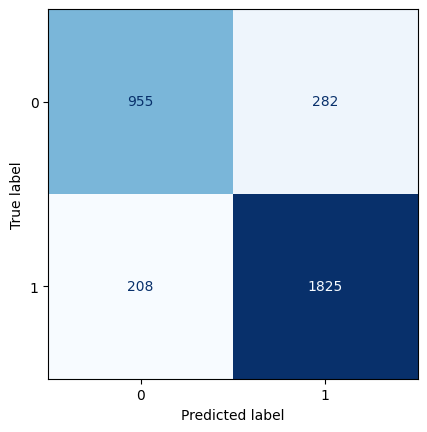

In [34]:
# Confusion matrix

fig = ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, colorbar=False, cmap='Blues')
run["_test/plots/confusion_matrix"].upload(fig.figure_)

In [35]:
# Checking the run metadata

while '_test' not in run.fetch(): time.sleep(0.1)
run.fetch()

{'_dev': {'epoch_0': {'accuracy': 0.8176033934252386},
  'epoch_1': {'accuracy': 0.848356309650053},
  'epoch_2': {'accuracy': 0.8451749734888653}},
 '_test': {'accuracy': 0.8501529051987767, 'plots': {}},
 '_train': {'epoch_0': {}, 'epoch_1': {}, 'epoch_2': {}},
 'data': {'metadata': {'dev_size': 943, 'train_size': 8484, 'val_size': 3270}},
 'device': 'cuda',
 'model': {'id': 'LSML2-BRT',
  'name': 'roberta-large',
  'url': 'https://app.neptune.ai/inbox225710/project-lsml2/m/LSML2-BRT/v/LSML2-BRT-1',
  'version_id': 'LSML2-BRT-1'},
 'monitoring': {'2e09e48b': {'hostname': 'add99e4cd4a8',
   'pid': '152',
   'tid': '140683691074176'}},
 'parameters': {'batch_size': 16,
  'epochs': 3,
  'epsilon': 1e-08,
  'learning_rate': 2e-05,
  'num_warmup_steps': 3,
  'optimizer_name': 'AdamW',
  'train_size': 0.9},
 'seed_val': 225,
 'source_code': {},
 'sys': {'creation_time': datetime.datetime(2024, 3, 10, 22, 5, 58, 863000, tzinfo=tzlocal()),
  'description': 'Finetuning pretrained model',
  'f

In [44]:
# Setting model path

#----------------------------------------------------#
MODEL_PATH = os.path.join(LOCAL_WORKDIR, f'{model_version["sys/id"].fetch()}.pth')
try:
    GDRIVE_PATH = os.path.join(GDRIVE_WORKDIR, f'{model_version["sys/id"].fetch()}.pth')
except Exception as err:
    print(err)
#----------------------------------------------------#

In [47]:
# Saving the model and uploading binary to the appropriate model_version

try:
    torch.save(text_model.state_dict(), GDRIVE_PATH)
except Exception as err:
    print(err)

torch.save(text_model.state_dict(), MODEL_PATH)
model_version["model/binary"].upload(MODEL_PATH)

In [48]:
# Creating new Neptune model_version object and promoting it to production

# with neptune.init_model(with_id=f"{PROJECT_KEY}-{MODEL_KEY}") as model:
#     model_version = neptune.init_model_version(model=model["sys/id"].fetch())
#     model_version.change_stage("production")

with model_version:
    model_version = neptune.init_model_version(model=model_version["sys/model_id"].fetch())
    model_version.change_stage("production")

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/inbox225710/project-lsml2/m/LSML2-BRT/v/LSML2-BRT-2
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/inbox225710/project-lsml2/m/LSML2-BRT/v/LSML2-BRT-1/metadata


In [49]:
# Stopping Neptune objects

run.stop()
model_version.stop()
project.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 1 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/inbox225710/project-lsml2/e/LSML2-2/metadata
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/inbox225710/project-lsml2/m/LSML2-BRT/v/LSML2-BRT-2/metadata
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/inbox225710/project-lsml2/meta

In [60]:
torch.cuda.empty_cache()

## 6. Serving the model

In [51]:
# Installing apps

! apt-get install redis-server -y
! pip install -q celery[redis]==4.4.7

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libjemalloc2 liblua5.1-0 liblzf1 lua-bitop lua-cjson redis-tools
Suggested packages:
  ruby-redis
The following NEW packages will be installed:
  libjemalloc2 liblua5.1-0 liblzf1 lua-bitop lua-cjson redis-server redis-tools
0 upgraded, 7 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,273 kB of archives.
After this operation, 5,725 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libjemalloc2 amd64 5.2.1-4ubuntu1 [240 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 liblua5.1-0 amd64 5.1.5-8.1build4 [99.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 liblzf1 amd64 3.6-3 [7,444 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 lua-bitop amd64 1.0.2-5 [6,680 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 lua-c

In [52]:
# Launching a Redis server process in the background and ensuring that it continues running even if the current terminal session is closed

! nohup redis-server &

nohup: appending output to 'nohup.out'


Writing necessary files.

In [53]:
%%writefile start-worker.sh
#!/bin/bash

set -e

export COMMAND="celery worker -A server:celery_app -c 1 > log-worker.txt 2>&1"

rm -r __pycache__/ 2> /dev/null || true

(tmux kill-session -t celery-worker 2> /dev/null || exit 0) && sleep 3 && tmux new -s celery-worker -d "$COMMAND" 2> /dev/null

echo "Success!"

Writing start-worker.sh


In [54]:
%%writefile launch-server.sh
#!/bin/bash

set -e

export COMMAND="python $1 > log.txt 2>&1"

rm -r __pycache__/ 2> /dev/null || true

(tmux kill-session -t flask-server 2> /dev/null || exit 0) && sleep 3 && tmux new -s flask-server -d "$COMMAND" 2> /dev/null

echo "Success!"

Writing launch-server.sh


In [55]:
# Getting the model path

#----------------------------------------------------#
print(MODEL_PATH)
try:
    print(GDRIVE_PATH)
except Exception as err:
    print(err)
#----------------------------------------------------#

workspace/LSML2-BRT-1.pth
/content/drive/MyDrive/_model/LSML2-BRT-1.pth


In [61]:
%%writefile server.py

import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from celery import Celery
from celery.result import AsyncResult
import time
from flask import Flask, request
import json

#------------------------------#
#           Settings           #
#------------------------------#
pretrained_model = 'roberta-large'
model_path = 'workspace/LSML2-BRT-1.pth'
max_length = 256
truncation = 'only_second'
#------------------------------#


device = torch.device("cpu")
celery_app = Celery('server', backend='redis://localhost', broker='redis://localhost')
app = Flask('__name__')


def load_model(model_path):
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
    model = AutoModelForSequenceClassification.from_pretrained(pretrained_model)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return tokenizer, model

tokenizer, model = load_model(model_path)


@celery_app.task
def predict(question, passage):
    encoding = tokenizer(question, passage, padding=True, return_tensors='pt', truncation=truncation, max_length=max_length)
    input_ids = encoding['input_ids'].to(device)
    logits = model(input_ids).logits

    probabilities = torch.softmax(logits, dim=1).detach().cpu().tolist()[0]
    proba_yes = probabilities[1]
    proba_no = probabilities[0]

    return [question, proba_yes, proba_no]


@app.route('/')
def hello():
    return f":: {time.ctime()} :: Server successfully launched and running ::"


@app.route('/predict', methods=["GET", "POST"])
def predict_handler():
    if request.method == 'POST':
        data = request.get_json(force=True)
        question, passage = data['question'], data['passage']
        task = predict.delay(question, passage)

        response = {
            "task_id": task.id
        }
        return json.dumps(response)

@app.route('/predict/<task_id>')
def predict_check_handler(task_id):
    task = AsyncResult(task_id, app=celery_app)
    if task.ready():
        response = {
            "status": "DONE",
            "result": task.result
        }
    else:
        response = {
            "status": "IN_PROGRESS"
        }
    return json.dumps(response)


if __name__ == '__main__':
    app.run("0.0.0.0", 8000, debug=True)

Overwriting server.py


In [62]:
# Running the worker and the server

!bash start-worker.sh
!bash launch-server.sh server.py

Success!
Success!


In [63]:
# Checking server state

!curl http://localhost:8000/

:: Sun Mar 10 22:40:13 2024 :: Server successfully launched and running ::

In [67]:
# Testing the application

#------------------------------#
start_idx = 10
slice_len = 15
#------------------------------#

questions = test_df.question[start_idx:start_idx+slice_len].values
passages = test_df.passage[start_idx:start_idx+slice_len].values

for idx, (question, passage) in enumerate(zip(questions, passages)):
    data = {
        'question': question,
        'passage': passage
    }

    response = requests.post("http://localhost:8000/predict", json=data)
    task_id = response.json()['task_id']
    status = "IN_PROGRESS"
    while status != "DONE":
        time.sleep(2.0)
        r = requests.get('http://localhost:8000/predict/{}'.format(task_id))
        status = r.json()['status']

    result = r.json()['result']
    print_string = f'Question: {result[0]}? :: Answer: {["YES", "NO"][np.argmax(result[1:])]} (yes: {result[1]:.2f}, no: {result[2]:.2f})'
    print(print_string)

Question: does volatility of a substance depend on its diffusivity? :: Answer: NO (yes: 0.01, no: 0.99)
Question: does the us military have a rail gun? :: Answer: NO (yes: 0.00, no: 1.00)
Question: can you supercharge and turbocharge at the same time? :: Answer: YES (yes: 1.00, no: 0.00)
Question: are they still making new episodes of the simpsons? :: Answer: YES (yes: 1.00, no: 0.00)
Question: are tom riddle and lord voldemort the same person? :: Answer: YES (yes: 1.00, no: 0.00)
Question: is it the law to pull over for an ambulance? :: Answer: YES (yes: 1.00, no: 0.00)
Question: is there such a thing as designated survivor? :: Answer: YES (yes: 1.00, no: 0.00)
Question: is st thomas virgin islands a us territory? :: Answer: YES (yes: 1.00, no: 0.00)
Question: are there fiber optic cables in the ocean? :: Answer: YES (yes: 1.00, no: 0.00)
Question: is a linked list an abstract data type? :: Answer: YES (yes: 1.00, no: 0.00)
Question: is tonight the last episode of jersey shore? :: Ans